In [1]:
import torch
x = torch.rand(5,3)
print(x)

tensor([[0.9184, 0.1933, 0.9204],
        [0.3625, 0.9613, 0.3963],
        [0.1142, 0.2644, 0.8398],
        [0.4394, 0.1617, 0.5893],
        [0.3602, 0.8296, 0.1577]])


## Data loaders
PyTorch offers domain-specific libraries such as TorchText, TorchVision, and TorchAudio, all of which include datasets. For this tutorial, we will be using a TorchVision dataset.

In [2]:
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt

Fetch data using the FashionMNIST dataset

In [5]:
#training data download
training_data = datasets.FashionMNIST(
    root = "data",
    train = True,
    download = True,
    transform = ToTensor(),    
)

#test data download
test_data = datasets.FashionMNIST(
    root = "data",
    train = False,
    download = True,
    transform = ToTensor(),
)

Pass the data to the data loader, specifying batch_size.
The data loader performs automatic batching, sampling and shuffling.

In [8]:
batch_size = 64
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print("Shape of X[N,C,H,W]: ", X.shape)
    print("shape of y: ", y.shape, y.dtype)
    break

Shape of X[N,C,H,W]:  torch.Size([64, 1, 28, 28])
shape of y:  torch.Size([64]) torch.int64


In [ ]:
Visualize the data

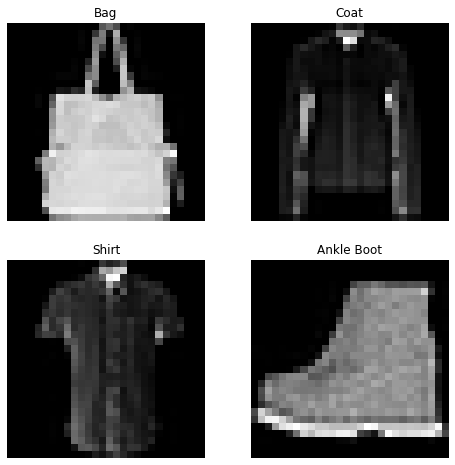

In [12]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 2, 2
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

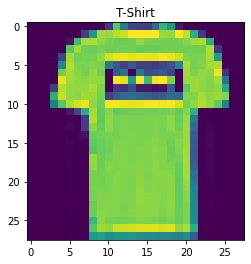

In [36]:
#Indexing a simple datapoint
img, label = training_data[1]
plt.title(labels_map[label])
plt.imshow(img.squeeze())

## Creating Models

* The construction `__init__` constsin the layers used for the model
* the method  ` forward ` specifies how the data will pass through the network
* To accelerate the operations, the code is moved to the GPU in case it is available (not in MAC)

In [39]:
#setup GPU-CPU 
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

#define the model object
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )
    
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
    
#instantiate model
model = NeuralNetwork().to(device)
print(model)

        

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [44]:
#perform a single pass
img, label = training_data[1]
y = model(img)
print(y)

tensor([[-0.1195, -0.0252,  0.0565,  0.0219,  0.0405,  0.0277,  0.0924,  0.1351,
         -0.0191, -0.0853]], grad_fn=<AddmmBackward0>)


# Optimization Process
* Loss function
* Optimizer

In [50]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

# Training function
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset) #length of the dataset
    model.train() # ??
    
    for batch, (X,y) in enumerate(dataloader):
        X,y = X.to(device), y.to(device)
        
        #compute prediction
        pred = model(X)
        loss = loss_fn(pred, y)
        
        #backpropagation
        optimizer.zero_grad() # ??
        loss.backward() # ??
        optimizer.step() 
        
        if batch %100 ==0:
            loss, current = loss.item(), batch*len(X)
            print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")

# Testing function
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()# ??
    test_loss, correct = 0, 0
    with torch.no_grad(): # ??
        for X, y in dataloader:
            X,y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item() # ??
            correct += (pred.argmax(1)==y).type(torch.float).sum().item()
            
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    
#epoch-based training
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n---------------------------")
    train(train_dataloader,model, loss_fn, optimizer)
    test(test_dataloader,model, loss_fn)
    
print("Done")

Epoch 1
---------------------------
loss: 2.299199 [    0/60000]
loss: 2.291617 [ 6400/60000]
loss: 2.266948 [12800/60000]
loss: 2.262112 [19200/60000]
loss: 2.253780 [25600/60000]
loss: 2.217607 [32000/60000]
loss: 2.226882 [38400/60000]
loss: 2.192563 [44800/60000]
loss: 2.183422 [51200/60000]
loss: 2.153728 [57600/60000]
Test Error: 
 Accuracy: 48.4%, Avg loss: 2.150947 

Epoch 2
---------------------------
loss: 2.159213 [    0/60000]
loss: 2.153966 [ 6400/60000]
loss: 2.089461 [12800/60000]
loss: 2.104732 [19200/60000]
loss: 2.058248 [25600/60000]
loss: 1.996138 [32000/60000]
loss: 2.021597 [38400/60000]
loss: 1.939839 [44800/60000]
loss: 1.935037 [51200/60000]
loss: 1.874413 [57600/60000]
Test Error: 
 Accuracy: 58.6%, Avg loss: 1.869958 

Epoch 3
---------------------------
loss: 1.898859 [    0/60000]
loss: 1.874653 [ 6400/60000]
loss: 1.748909 [12800/60000]
loss: 1.794484 [19200/60000]
loss: 1.688751 [25600/60000]
loss: 1.643425 [32000/60000]
loss: 1.667732 [38400/60000]
loss:

In [57]:
for a,(x,y) in enumerate(train_dataloader):
    print(a)
    print(y)

0
tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5, 0, 9, 5, 5, 7, 9, 1, 0, 6, 4, 3, 1, 4, 8,
        4, 3, 0, 2, 4, 4, 5, 3, 6, 6, 0, 8, 5, 2, 1, 6, 6, 7, 9, 5, 9, 2, 7, 3,
        0, 3, 3, 3, 7, 2, 2, 6, 6, 8, 3, 3, 5, 0, 5, 5])
1
tensor([0, 2, 0, 0, 4, 1, 3, 1, 6, 3, 1, 4, 4, 6, 1, 9, 1, 3, 5, 7, 9, 7, 1, 7,
        9, 9, 9, 3, 2, 9, 3, 6, 4, 1, 1, 8, 8, 0, 1, 1, 6, 8, 1, 9, 7, 8, 8, 9,
        6, 6, 3, 1, 5, 4, 6, 7, 5, 5, 9, 2, 2, 2, 7, 6])
2
tensor([4, 1, 8, 7, 7, 5, 4, 2, 9, 1, 7, 4, 6, 9, 7, 1, 8, 7, 1, 2, 8, 0, 9, 1,
        8, 7, 0, 5, 8, 6, 7, 2, 0, 8, 7, 1, 6, 2, 1, 9, 6, 0, 1, 0, 5, 5, 1, 7,
        0, 5, 8, 4, 0, 4, 0, 6, 6, 4, 0, 0, 4, 7, 3, 0])
3
tensor([5, 8, 4, 1, 1, 2, 9, 2, 8, 5, 0, 6, 3, 4, 6, 0, 9, 1, 7, 3, 8, 5, 8, 3,
        8, 5, 2, 0, 8, 7, 0, 3, 5, 0, 6, 5, 2, 7, 5, 2, 6, 8, 2, 6, 8, 0, 4, 4,
        4, 4, 4, 1, 5, 6, 5, 3, 3, 7, 3, 3, 6, 2, 8, 4])
4
tensor([6, 5, 9, 3, 2, 3, 2, 4, 4, 8, 2, 5, 3, 0, 7, 2, 0, 2, 5, 7, 2, 3, 1, 7,
        6, 2, 9, 1, 9, 1, 1, 8, 7, 8, 4, 2

tensor([6, 5, 2, 2, 1, 8, 7, 7, 4, 1, 7, 7, 2, 3, 5, 2, 3, 5, 8, 6, 7, 4, 0, 4,
        2, 3, 2, 7, 9, 8, 1, 5, 1, 8, 0, 2, 3, 5, 8, 4, 6, 0, 8, 3, 4, 9, 7, 1,
        7, 9, 8, 6, 7, 4, 5, 0, 9, 1, 2, 6, 2, 0, 8, 3])
41
tensor([2, 3, 3, 7, 4, 4, 2, 7, 5, 5, 7, 6, 1, 9, 4, 0, 4, 7, 1, 9, 4, 3, 6, 1,
        7, 2, 6, 1, 4, 9, 0, 6, 8, 2, 6, 8, 6, 3, 5, 6, 1, 7, 5, 9, 3, 1, 1, 9,
        6, 7, 5, 9, 1, 4, 2, 8, 4, 5, 1, 1, 1, 4, 7, 2])
42
tensor([9, 9, 7, 1, 9, 4, 3, 0, 8, 1, 0, 8, 6, 1, 2, 8, 3, 4, 5, 0, 6, 4, 8, 5,
        0, 6, 4, 4, 6, 3, 3, 6, 1, 5, 9, 3, 9, 4, 8, 9, 3, 6, 0, 3, 2, 2, 1, 5,
        8, 7, 8, 5, 9, 0, 9, 4, 3, 0, 5, 9, 6, 3, 1, 7])
43
tensor([3, 0, 2, 3, 3, 6, 9, 0, 8, 8, 8, 8, 1, 3, 7, 7, 8, 7, 2, 7, 0, 4, 6, 6,
        3, 8, 5, 1, 8, 1, 8, 2, 9, 4, 2, 4, 6, 1, 5, 7, 8, 9, 8, 0, 5, 1, 6, 1,
        3, 8, 4, 3, 9, 5, 6, 5, 1, 0, 7, 6, 2, 3, 6, 9])
44
tensor([4, 3, 9, 5, 3, 3, 4, 7, 7, 6, 7, 2, 7, 3, 2, 3, 0, 0, 9, 7, 9, 8, 9, 6,
        8, 7, 4, 6, 9, 3, 9, 6, 3, 1, 6,

88
tensor([9, 7, 9, 2, 5, 1, 9, 6, 1, 1, 7, 8, 6, 8, 7, 8, 3, 6, 7, 3, 2, 9, 9, 7,
        7, 1, 3, 1, 5, 1, 0, 2, 4, 5, 5, 7, 6, 5, 2, 5, 2, 8, 1, 3, 7, 7, 8, 6,
        9, 5, 5, 0, 6, 6, 1, 2, 3, 7, 5, 1, 6, 7, 7, 3])
89
tensor([2, 5, 2, 8, 8, 1, 0, 0, 8, 6, 3, 4, 7, 1, 9, 5, 6, 7, 6, 2, 2, 2, 7, 8,
        9, 7, 1, 1, 1, 4, 0, 7, 0, 7, 5, 9, 6, 0, 9, 4, 2, 0, 4, 6, 2, 7, 4, 0,
        7, 0, 7, 4, 6, 5, 8, 0, 5, 3, 9, 4, 7, 4, 0, 4])
90
tensor([7, 3, 1, 8, 6, 2, 5, 6, 3, 3, 2, 5, 4, 2, 0, 4, 8, 8, 7, 6, 8, 5, 7, 4,
        3, 0, 7, 9, 4, 5, 6, 6, 0, 3, 8, 6, 5, 4, 6, 8, 7, 1, 0, 0, 6, 7, 2, 1,
        4, 3, 7, 9, 0, 1, 5, 2, 5, 3, 3, 5, 5, 0, 1, 7])
91
tensor([9, 7, 5, 2, 1, 6, 1, 1, 4, 6, 9, 6, 6, 2, 0, 8, 4, 3, 2, 2, 9, 3, 7, 7,
        7, 8, 1, 3, 9, 6, 4, 9, 9, 7, 5, 7, 5, 6, 9, 0, 2, 3, 8, 9, 3, 3, 0, 2,
        2, 5, 3, 2, 4, 3, 3, 4, 7, 5, 9, 4, 5, 7, 0, 8])
92
tensor([3, 0, 1, 9, 3, 8, 0, 2, 9, 5, 5, 9, 8, 1, 4, 7, 1, 5, 3, 9, 6, 1, 3, 2,
        3, 4, 0, 7, 5, 2, 0, 3, 8, 8,

133
tensor([8, 4, 0, 4, 9, 8, 4, 9, 6, 1, 0, 2, 1, 4, 4, 1, 3, 4, 8, 9, 1, 9, 4, 7,
        5, 3, 8, 5, 6, 5, 6, 5, 0, 6, 7, 8, 7, 9, 4, 5, 3, 2, 3, 7, 1, 2, 2, 7,
        4, 8, 3, 9, 2, 2, 4, 6, 5, 4, 7, 9, 2, 1, 0, 1])
134
tensor([2, 3, 6, 5, 4, 8, 8, 8, 1, 3, 1, 2, 2, 4, 0, 6, 7, 2, 5, 3, 2, 1, 9, 9,
        0, 0, 4, 2, 9, 8, 8, 3, 8, 7, 1, 7, 6, 5, 6, 5, 9, 9, 6, 8, 1, 4, 2, 7,
        4, 4, 1, 5, 5, 3, 6, 1, 8, 9, 1, 2, 6, 0, 7, 6])
135
tensor([4, 2, 4, 8, 4, 1, 8, 3, 0, 3, 6, 9, 6, 4, 4, 1, 1, 6, 3, 2, 4, 7, 2, 1,
        8, 2, 4, 3, 6, 4, 8, 2, 0, 7, 4, 6, 9, 7, 4, 9, 9, 3, 8, 4, 7, 3, 1, 9,
        4, 0, 9, 4, 0, 2, 0, 8, 7, 0, 7, 0, 6, 0, 3, 6])
136
tensor([6, 4, 6, 5, 4, 6, 8, 3, 1, 3, 3, 5, 0, 6, 0, 3, 9, 9, 8, 9, 1, 2, 8, 7,
        4, 0, 5, 9, 3, 0, 3, 6, 2, 7, 1, 7, 7, 7, 9, 0, 2, 8, 4, 4, 9, 1, 6, 2,
        7, 7, 7, 2, 0, 0, 8, 7, 3, 9, 4, 2, 2, 5, 4, 8])
137
tensor([3, 2, 6, 7, 3, 2, 7, 2, 9, 1, 5, 6, 0, 0, 3, 9, 3, 5, 8, 4, 3, 0, 0, 4,
        1, 4, 7, 6, 9, 2, 2, 9, 

tensor([3, 3, 1, 6, 6, 8, 7, 9, 5, 5, 9, 8, 7, 4, 2, 8, 6, 9, 6, 5, 6, 7, 7, 6,
        1, 1, 9, 4, 6, 0, 3, 2, 7, 8, 2, 3, 4, 9, 8, 1, 0, 8, 8, 0, 1, 0, 3, 4,
        1, 7, 9, 0, 7, 1, 1, 4, 4, 9, 2, 5, 7, 2, 5, 4])
175
tensor([8, 4, 6, 7, 8, 8, 4, 4, 4, 6, 5, 3, 9, 7, 4, 9, 3, 1, 1, 0, 7, 1, 9, 4,
        3, 2, 3, 6, 0, 7, 8, 0, 3, 5, 5, 9, 8, 8, 9, 9, 8, 2, 6, 8, 1, 9, 4, 6,
        3, 2, 7, 8, 6, 1, 8, 7, 0, 8, 5, 6, 6, 9, 9, 5])
176
tensor([3, 6, 8, 0, 1, 1, 4, 5, 9, 8, 2, 3, 0, 4, 7, 5, 0, 9, 7, 7, 3, 9, 9, 6,
        2, 0, 4, 3, 0, 7, 6, 6, 7, 6, 1, 6, 4, 3, 5, 6, 4, 9, 2, 9, 1, 6, 2, 4,
        5, 6, 0, 5, 8, 1, 5, 5, 9, 9, 9, 5, 1, 4, 7, 0])
177
tensor([3, 1, 1, 3, 0, 9, 8, 3, 4, 3, 1, 1, 0, 5, 6, 3, 1, 7, 5, 1, 8, 3, 3, 9,
        5, 2, 8, 8, 2, 5, 1, 4, 2, 5, 8, 1, 2, 4, 8, 8, 5, 9, 2, 4, 6, 0, 2, 4,
        3, 5, 4, 7, 9, 4, 0, 2, 2, 8, 7, 4, 6, 1, 8, 1])
178
tensor([6, 8, 6, 3, 8, 2, 7, 1, 9, 7, 0, 1, 8, 3, 4, 5, 4, 2, 1, 1, 1, 2, 9, 1,
        0, 6, 1, 3, 0, 8, 0, 5, 7, 3

tensor([8, 8, 1, 0, 2, 9, 8, 2, 2, 3, 2, 5, 3, 4, 0, 4, 7, 0, 1, 8, 8, 5, 3, 9,
        6, 9, 5, 0, 9, 2, 0, 2, 9, 0, 9, 9, 7, 6, 1, 1, 3, 2, 5, 2, 0, 0, 1, 7,
        8, 9, 8, 4, 7, 4, 8, 1, 3, 5, 2, 6, 0, 9, 0, 1])
218
tensor([0, 7, 2, 2, 6, 3, 6, 8, 1, 2, 7, 0, 6, 4, 4, 7, 4, 3, 8, 4, 6, 4, 5, 2,
        9, 3, 2, 8, 5, 3, 3, 7, 0, 5, 9, 6, 1, 7, 6, 9, 8, 3, 1, 2, 5, 7, 4, 2,
        0, 9, 2, 3, 1, 3, 6, 7, 5, 5, 3, 6, 0, 1, 9, 6])
219
tensor([4, 9, 2, 5, 4, 5, 7, 7, 6, 4, 6, 2, 0, 3, 6, 4, 5, 9, 1, 4, 4, 3, 7, 3,
        8, 5, 7, 0, 9, 4, 8, 9, 9, 0, 1, 4, 0, 9, 1, 2, 2, 4, 7, 5, 2, 7, 5, 9,
        3, 6, 7, 6, 8, 3, 4, 5, 3, 9, 4, 5, 5, 0, 3, 7])
220
tensor([6, 0, 7, 1, 1, 8, 4, 5, 8, 0, 8, 2, 1, 1, 1, 1, 4, 6, 5, 2, 5, 5, 8, 5,
        6, 2, 6, 3, 2, 9, 4, 2, 7, 6, 5, 9, 8, 7, 9, 1, 8, 9, 4, 6, 8, 5, 3, 5,
        5, 9, 3, 8, 2, 9, 4, 6, 7, 6, 4, 4, 9, 5, 2, 8])
221
tensor([6, 0, 1, 3, 2, 0, 5, 9, 1, 4, 7, 6, 3, 5, 6, 9, 0, 8, 2, 1, 6, 1, 9, 2,
        8, 2, 7, 5, 3, 1, 6, 7, 2, 3

259
tensor([9, 2, 9, 1, 3, 4, 4, 5, 6, 2, 1, 5, 3, 7, 3, 2, 3, 1, 0, 1, 7, 9, 5, 0,
        0, 3, 6, 5, 8, 5, 5, 2, 6, 9, 3, 2, 4, 9, 4, 6, 5, 2, 4, 6, 1, 2, 1, 6,
        4, 1, 9, 1, 1, 2, 1, 9, 1, 6, 9, 1, 5, 5, 5, 6])
260
tensor([6, 6, 0, 7, 2, 9, 8, 7, 2, 8, 2, 7, 2, 8, 0, 4, 7, 1, 6, 5, 6, 0, 5, 0,
        1, 4, 8, 8, 7, 8, 7, 7, 8, 3, 2, 9, 3, 9, 8, 8, 6, 1, 2, 2, 8, 3, 5, 9,
        3, 2, 5, 4, 6, 7, 1, 1, 7, 9, 4, 2, 1, 7, 0, 3])
261
tensor([6, 2, 4, 6, 8, 6, 2, 7, 9, 8, 6, 2, 3, 2, 5, 3, 0, 9, 2, 8, 8, 8, 0, 7,
        9, 6, 1, 5, 5, 6, 4, 4, 4, 3, 6, 3, 0, 7, 0, 9, 2, 0, 7, 2, 3, 9, 5, 9,
        3, 1, 7, 2, 8, 7, 0, 9, 9, 8, 2, 5, 4, 0, 8, 9])
262
tensor([0, 0, 2, 5, 4, 9, 9, 5, 6, 2, 8, 2, 0, 6, 2, 7, 9, 2, 6, 9, 4, 3, 2, 8,
        1, 7, 6, 7, 7, 8, 1, 3, 9, 3, 9, 4, 4, 2, 1, 6, 4, 9, 6, 7, 4, 9, 0, 1,
        9, 9, 6, 3, 8, 4, 0, 4, 8, 7, 2, 2, 2, 2, 2, 7])
263
tensor([4, 4, 2, 6, 1, 6, 9, 0, 6, 6, 7, 5, 6, 7, 1, 1, 8, 5, 9, 1, 5, 5, 6, 8,
        1, 0, 0, 3, 9, 5, 3, 5, 

299
tensor([8, 0, 3, 0, 6, 0, 2, 0, 4, 6, 8, 9, 2, 5, 2, 8, 0, 6, 4, 7, 8, 2, 9, 1,
        3, 5, 2, 7, 1, 5, 4, 0, 0, 2, 3, 4, 7, 4, 9, 4, 2, 1, 6, 9, 8, 0, 4, 4,
        4, 5, 9, 8, 4, 8, 8, 3, 4, 6, 7, 3, 5, 8, 8, 1])
300
tensor([4, 5, 9, 7, 5, 7, 1, 3, 8, 8, 2, 8, 6, 9, 8, 8, 2, 0, 4, 4, 3, 1, 1, 1,
        1, 2, 1, 4, 7, 7, 3, 2, 5, 6, 4, 8, 3, 8, 4, 7, 4, 3, 1, 6, 6, 9, 4, 3,
        7, 1, 9, 5, 8, 5, 6, 3, 3, 6, 2, 7, 0, 0, 8, 9])
301
tensor([2, 3, 8, 1, 0, 9, 5, 2, 1, 2, 3, 3, 9, 3, 4, 2, 9, 5, 7, 8, 7, 9, 8, 5,
        3, 8, 0, 0, 9, 2, 3, 8, 0, 8, 0, 6, 9, 0, 7, 8, 4, 8, 7, 9, 0, 3, 2, 1,
        6, 5, 8, 6, 6, 2, 9, 6, 4, 3, 6, 7, 7, 4, 0, 5])
302
tensor([2, 8, 0, 2, 2, 9, 6, 2, 0, 6, 7, 2, 1, 1, 6, 8, 9, 6, 5, 7, 3, 1, 0, 0,
        9, 7, 2, 4, 7, 6, 6, 8, 9, 1, 4, 1, 1, 0, 5, 7, 4, 5, 4, 3, 6, 4, 1, 2,
        1, 0, 1, 5, 6, 1, 6, 8, 7, 5, 5, 6, 6, 9, 1, 1])
303
tensor([1, 9, 3, 1, 5, 4, 5, 2, 9, 7, 6, 0, 3, 4, 7, 5, 9, 5, 9, 9, 8, 3, 3, 4,
        7, 0, 7, 0, 1, 2, 9, 6, 

345
tensor([8, 0, 3, 2, 2, 7, 0, 2, 3, 4, 2, 9, 9, 4, 3, 7, 0, 5, 5, 6, 8, 3, 0, 2,
        8, 8, 0, 5, 6, 3, 1, 4, 3, 0, 1, 0, 6, 7, 6, 3, 5, 0, 4, 7, 1, 8, 3, 4,
        3, 0, 6, 6, 1, 4, 4, 0, 1, 0, 5, 4, 3, 2, 1, 1])
346
tensor([9, 7, 9, 0, 4, 5, 1, 3, 9, 3, 7, 9, 7, 1, 7, 2, 2, 4, 5, 5, 0, 3, 5, 6,
        5, 5, 5, 9, 0, 1, 7, 6, 9, 1, 6, 9, 4, 2, 0, 1, 0, 2, 5, 3, 5, 7, 2, 1,
        9, 0, 1, 5, 8, 1, 2, 5, 0, 9, 6, 5, 7, 1, 9, 9])
347
tensor([6, 4, 8, 3, 6, 9, 9, 0, 0, 8, 0, 4, 4, 2, 9, 4, 2, 7, 1, 0, 0, 4, 1, 7,
        5, 4, 5, 7, 4, 0, 5, 1, 6, 7, 6, 4, 3, 6, 9, 2, 1, 9, 4, 5, 5, 9, 4, 5,
        5, 7, 7, 6, 9, 9, 2, 1, 0, 9, 8, 4, 5, 7, 9, 8])
348
tensor([3, 6, 2, 4, 6, 5, 3, 8, 7, 9, 3, 0, 1, 4, 3, 9, 3, 3, 8, 4, 6, 5, 3, 3,
        3, 6, 6, 5, 1, 3, 8, 3, 2, 9, 4, 5, 4, 0, 5, 1, 2, 1, 5, 3, 3, 4, 3, 9,
        5, 2, 3, 3, 1, 0, 5, 6, 2, 0, 0, 9, 1, 0, 2, 2])
349
tensor([0, 4, 3, 5, 4, 7, 8, 7, 9, 8, 5, 3, 9, 4, 5, 7, 8, 6, 2, 2, 5, 6, 1, 4,
        8, 1, 3, 5, 7, 8, 0, 9, 

394
tensor([0, 5, 5, 8, 8, 1, 4, 6, 5, 8, 0, 0, 0, 9, 3, 1, 1, 1, 1, 9, 3, 2, 2, 6,
        8, 7, 8, 5, 4, 2, 0, 0, 0, 2, 4, 0, 8, 2, 7, 6, 9, 5, 0, 7, 9, 0, 0, 7,
        5, 1, 1, 1, 6, 2, 2, 2, 9, 5, 4, 9, 3, 7, 8, 7])
395
tensor([2, 9, 3, 3, 7, 0, 1, 0, 3, 0, 3, 0, 4, 9, 2, 6, 1, 7, 3, 5, 1, 9, 2, 3,
        3, 1, 5, 8, 7, 3, 1, 5, 4, 3, 9, 4, 8, 5, 9, 9, 9, 2, 7, 3, 0, 4, 8, 2,
        8, 2, 9, 0, 6, 4, 8, 0, 1, 1, 6, 2, 4, 4, 0, 1])
396
tensor([7, 8, 3, 8, 8, 6, 5, 5, 3, 0, 3, 0, 9, 4, 8, 9, 7, 9, 0, 8, 4, 4, 9, 7,
        8, 8, 3, 3, 7, 4, 3, 5, 7, 3, 1, 5, 6, 5, 8, 7, 8, 7, 2, 3, 9, 8, 1, 8,
        1, 1, 6, 5, 0, 0, 0, 3, 6, 3, 2, 3, 5, 5, 7, 6])
397
tensor([4, 4, 2, 5, 5, 2, 7, 5, 4, 2, 6, 0, 9, 9, 6, 2, 1, 3, 1, 9, 8, 7, 1, 4,
        4, 8, 0, 2, 9, 2, 6, 6, 0, 4, 4, 4, 7, 3, 7, 5, 6, 4, 9, 1, 5, 5, 4, 3,
        4, 5, 9, 6, 1, 5, 9, 6, 0, 0, 5, 3, 1, 8, 8, 8])
398
tensor([2, 0, 3, 5, 4, 9, 8, 8, 5, 8, 0, 3, 2, 1, 9, 8, 9, 6, 8, 9, 0, 0, 0, 0,
        9, 1, 9, 5, 0, 0, 2, 5, 

444
tensor([9, 8, 5, 4, 2, 3, 6, 1, 9, 0, 9, 4, 7, 6, 9, 3, 7, 2, 5, 1, 7, 1, 9, 9,
        0, 2, 8, 2, 1, 2, 2, 0, 1, 8, 5, 0, 5, 0, 5, 1, 1, 5, 9, 8, 8, 0, 5, 6,
        6, 3, 4, 4, 8, 2, 0, 8, 5, 7, 0, 3, 7, 2, 6, 2])
445
tensor([6, 3, 8, 5, 3, 3, 8, 3, 6, 2, 3, 4, 0, 6, 9, 8, 4, 5, 3, 5, 2, 4, 2, 2,
        5, 3, 1, 3, 0, 0, 0, 5, 6, 3, 4, 4, 6, 6, 0, 5, 1, 8, 3, 3, 6, 4, 8, 1,
        7, 1, 2, 6, 8, 6, 6, 4, 2, 2, 6, 8, 1, 4, 9, 3])
446
tensor([7, 8, 8, 1, 4, 8, 3, 6, 8, 8, 9, 0, 4, 9, 1, 4, 6, 2, 9, 9, 7, 3, 0, 4,
        7, 7, 1, 6, 0, 6, 9, 3, 5, 6, 7, 2, 9, 9, 3, 9, 6, 1, 4, 7, 7, 4, 8, 8,
        8, 5, 1, 4, 2, 1, 3, 3, 8, 2, 8, 8, 9, 1, 3, 8])
447
tensor([6, 7, 8, 7, 9, 4, 1, 1, 4, 1, 6, 2, 5, 2, 3, 8, 2, 3, 3, 3, 3, 7, 6, 1,
        4, 6, 9, 0, 0, 7, 3, 7, 3, 8, 3, 7, 5, 8, 2, 6, 0, 4, 7, 4, 8, 0, 7, 3,
        1, 6, 5, 0, 0, 9, 7, 6, 1, 0, 3, 7, 1, 0, 5, 3])
448
tensor([9, 6, 4, 8, 7, 0, 6, 9, 2, 4, 6, 4, 6, 6, 5, 3, 0, 6, 5, 6, 1, 8, 8, 2,
        6, 7, 8, 1, 4, 5, 6, 9, 

494
tensor([9, 1, 4, 3, 8, 2, 3, 3, 5, 4, 8, 3, 0, 4, 4, 4, 0, 0, 2, 8, 4, 5, 1, 0,
        2, 9, 1, 7, 8, 9, 4, 8, 7, 0, 7, 9, 3, 1, 4, 9, 7, 7, 7, 6, 0, 9, 8, 8,
        4, 6, 1, 5, 2, 6, 7, 2, 4, 5, 0, 3, 3, 7, 5, 5])
495
tensor([7, 3, 3, 3, 0, 1, 6, 4, 8, 5, 1, 2, 4, 9, 4, 4, 2, 0, 8, 1, 3, 4, 6, 8,
        6, 8, 7, 6, 0, 9, 4, 1, 3, 4, 1, 1, 7, 1, 3, 1, 1, 6, 7, 0, 3, 3, 0, 1,
        4, 9, 6, 9, 3, 2, 0, 1, 2, 6, 2, 8, 5, 2, 9, 3])
496
tensor([9, 4, 9, 0, 1, 2, 0, 8, 3, 7, 7, 4, 7, 6, 4, 1, 4, 7, 6, 9, 6, 0, 6, 1,
        1, 6, 1, 1, 0, 5, 2, 2, 6, 2, 6, 7, 6, 4, 4, 4, 3, 9, 0, 8, 3, 2, 0, 9,
        1, 0, 9, 4, 6, 1, 4, 5, 7, 1, 1, 3, 5, 9, 1, 3])
497
tensor([9, 5, 2, 2, 1, 0, 6, 0, 5, 1, 2, 4, 2, 5, 5, 7, 2, 8, 6, 2, 8, 0, 5, 7,
        1, 7, 8, 4, 6, 5, 3, 4, 4, 4, 7, 6, 0, 7, 6, 9, 2, 9, 7, 3, 0, 4, 2, 4,
        9, 4, 7, 0, 2, 7, 5, 9, 0, 4, 4, 3, 4, 0, 5, 2])
498
tensor([4, 8, 9, 8, 5, 0, 7, 0, 4, 3, 8, 3, 2, 2, 2, 8, 1, 5, 6, 0, 9, 5, 2, 8,
        9, 5, 3, 9, 8, 4, 3, 3, 

544
tensor([9, 0, 4, 2, 8, 4, 2, 9, 6, 5, 3, 6, 5, 6, 4, 7, 0, 8, 2, 5, 2, 2, 0, 8,
        2, 3, 0, 2, 7, 3, 6, 4, 4, 5, 7, 8, 7, 8, 7, 1, 0, 0, 0, 9, 7, 8, 3, 6,
        8, 5, 7, 6, 8, 9, 8, 0, 2, 9, 8, 6, 4, 2, 8, 1])
545
tensor([9, 5, 0, 8, 4, 2, 4, 3, 9, 2, 7, 9, 3, 3, 4, 0, 4, 6, 5, 1, 4, 2, 9, 9,
        9, 2, 3, 6, 5, 3, 8, 9, 0, 5, 7, 6, 9, 7, 1, 4, 0, 4, 2, 7, 3, 0, 1, 2,
        6, 7, 8, 7, 4, 4, 6, 4, 1, 7, 8, 9, 9, 2, 9, 6])
546
tensor([5, 2, 8, 5, 1, 1, 3, 2, 5, 1, 5, 2, 1, 3, 8, 5, 2, 2, 1, 5, 4, 3, 8, 8,
        7, 2, 5, 6, 2, 6, 9, 0, 4, 2, 1, 1, 0, 8, 3, 6, 9, 3, 4, 5, 8, 5, 1, 1,
        1, 8, 3, 9, 6, 8, 1, 9, 5, 2, 9, 2, 7, 1, 8, 7])
547
tensor([2, 4, 8, 7, 7, 2, 5, 3, 1, 7, 0, 2, 7, 2, 5, 5, 2, 7, 1, 7, 6, 9, 4, 6,
        4, 6, 7, 1, 7, 5, 3, 3, 0, 7, 3, 4, 4, 4, 9, 9, 8, 6, 1, 1, 2, 4, 4, 2,
        0, 2, 6, 7, 1, 8, 3, 0, 9, 1, 9, 7, 1, 2, 2, 1])
548
tensor([6, 5, 3, 5, 2, 8, 5, 8, 5, 4, 9, 9, 4, 6, 9, 6, 8, 6, 8, 6, 1, 8, 9, 0,
        9, 8, 7, 2, 0, 6, 5, 4, 

595
tensor([6, 9, 3, 7, 0, 6, 2, 9, 7, 6, 9, 2, 7, 9, 1, 9, 6, 2, 3, 0, 8, 0, 2, 4,
        4, 7, 5, 7, 3, 2, 0, 9, 4, 6, 8, 3, 2, 8, 7, 9, 1, 4, 4, 6, 7, 8, 0, 2,
        7, 4, 8, 8, 6, 7, 5, 5, 7, 2, 4, 4, 5, 1, 6, 1])
596
tensor([3, 4, 0, 1, 1, 7, 1, 4, 9, 8, 4, 7, 6, 8, 0, 0, 0, 3, 4, 2, 7, 7, 2, 9,
        4, 8, 5, 0, 7, 8, 4, 7, 6, 4, 7, 2, 7, 3, 5, 6, 2, 1, 2, 5, 8, 6, 1, 0,
        3, 9, 4, 3, 1, 7, 0, 8, 8, 3, 5, 5, 9, 9, 7, 3])
597
tensor([9, 1, 5, 1, 0, 7, 1, 4, 4, 5, 9, 3, 4, 1, 8, 4, 8, 0, 8, 8, 3, 5, 6, 7,
        0, 7, 3, 1, 0, 3, 4, 8, 9, 3, 0, 5, 9, 8, 9, 8, 7, 0, 2, 6, 6, 1, 2, 6,
        5, 3, 9, 5, 9, 8, 3, 7, 0, 0, 1, 9, 5, 3, 2, 6])
598
tensor([2, 8, 3, 8, 5, 0, 9, 1, 9, 7, 8, 8, 9, 7, 8, 4, 6, 9, 9, 2, 5, 5, 4, 9,
        9, 1, 3, 7, 9, 1, 6, 2, 0, 0, 2, 3, 5, 3, 8, 6, 0, 2, 9, 3, 2, 3, 5, 8,
        0, 7, 9, 8, 4, 6, 4, 3, 0, 4, 3, 9, 1, 8, 8, 5])
599
tensor([4, 5, 0, 6, 8, 7, 0, 1, 7, 9, 4, 4, 0, 7, 6, 7, 4, 5, 0, 4, 1, 2, 4, 4,
        2, 1, 2, 3, 9, 8, 5, 5, 

645
tensor([4, 7, 5, 2, 0, 7, 8, 6, 8, 5, 1, 6, 4, 2, 0, 6, 5, 0, 5, 6, 5, 2, 6, 2,
        8, 3, 1, 1, 3, 6, 3, 0, 1, 6, 6, 6, 6, 2, 3, 1, 7, 7, 8, 2, 6, 4, 6, 8,
        3, 3, 7, 1, 7, 1, 7, 0, 7, 0, 8, 8, 2, 8, 6, 0])
646
tensor([8, 6, 4, 6, 7, 6, 8, 9, 6, 9, 1, 6, 3, 2, 3, 7, 9, 7, 3, 6, 6, 6, 8, 3,
        2, 5, 4, 5, 9, 2, 1, 9, 5, 9, 5, 6, 2, 7, 1, 5, 7, 7, 8, 2, 2, 6, 1, 9,
        2, 5, 1, 5, 1, 0, 7, 0, 9, 4, 1, 4, 8, 8, 6, 3])
647
tensor([8, 1, 3, 2, 8, 2, 3, 8, 0, 6, 4, 9, 9, 9, 4, 4, 5, 5, 2, 7, 9, 8, 3, 2,
        9, 9, 0, 0, 5, 4, 0, 2, 1, 9, 8, 5, 6, 5, 3, 0, 2, 6, 9, 4, 9, 3, 8, 8,
        9, 0, 5, 9, 7, 4, 2, 1, 3, 0, 5, 0, 4, 1, 5, 4])
648
tensor([4, 0, 7, 2, 3, 5, 7, 1, 5, 0, 6, 8, 3, 2, 2, 0, 2, 4, 2, 6, 1, 8, 9, 2,
        0, 3, 8, 8, 4, 9, 4, 7, 9, 3, 2, 4, 0, 0, 3, 6, 5, 6, 1, 0, 8, 6, 5, 9,
        2, 1, 7, 7, 4, 4, 8, 4, 9, 9, 3, 3, 7, 4, 8, 3])
649
tensor([8, 4, 4, 7, 4, 9, 8, 5, 0, 7, 5, 8, 1, 4, 3, 7, 4, 6, 8, 5, 5, 7, 3, 8,
        2, 4, 7, 7, 3, 1, 9, 7, 

692
tensor([2, 5, 7, 6, 5, 2, 1, 0, 1, 9, 1, 9, 8, 9, 8, 3, 2, 0, 6, 5, 8, 0, 0, 5,
        7, 9, 8, 9, 9, 0, 7, 6, 4, 2, 2, 0, 9, 9, 2, 0, 3, 5, 4, 6, 4, 1, 4, 8,
        7, 9, 9, 5, 5, 7, 6, 9, 7, 7, 5, 6, 0, 8, 1, 5])
693
tensor([4, 9, 8, 2, 6, 8, 9, 2, 0, 9, 9, 6, 8, 4, 7, 6, 5, 4, 4, 2, 1, 6, 1, 9,
        5, 9, 5, 2, 8, 0, 5, 8, 1, 5, 3, 8, 5, 6, 4, 9, 7, 0, 6, 2, 8, 6, 9, 7,
        3, 7, 3, 7, 3, 6, 9, 1, 9, 0, 1, 2, 1, 6, 7, 1])
694
tensor([6, 7, 6, 3, 8, 2, 6, 8, 1, 4, 5, 1, 6, 6, 8, 6, 1, 3, 2, 0, 4, 9, 4, 3,
        5, 8, 5, 4, 5, 5, 6, 2, 8, 2, 0, 4, 1, 7, 3, 3, 3, 2, 6, 0, 7, 8, 8, 1,
        3, 9, 0, 6, 5, 9, 9, 2, 0, 1, 0, 5, 5, 5, 7, 6])
695
tensor([8, 8, 9, 8, 4, 9, 9, 5, 4, 1, 3, 5, 3, 5, 5, 5, 3, 3, 0, 7, 0, 7, 9, 2,
        3, 1, 9, 0, 8, 9, 0, 9, 4, 2, 4, 9, 3, 9, 1, 3, 5, 2, 3, 1, 3, 2, 2, 6,
        1, 6, 9, 4, 5, 7, 9, 4, 5, 3, 5, 3, 3, 3, 2, 7])
696
tensor([3, 7, 0, 4, 3, 3, 0, 2, 4, 6, 6, 3, 6, 0, 7, 8, 1, 0, 9, 3, 2, 2, 9, 8,
        6, 8, 5, 4, 9, 5, 6, 6, 

741
tensor([1, 8, 1, 2, 7, 5, 3, 8, 9, 3, 9, 7, 9, 8, 5, 9, 1, 4, 7, 4, 9, 9, 5, 7,
        7, 2, 4, 1, 6, 2, 7, 5, 3, 8, 0, 5, 2, 6, 6, 4, 5, 4, 4, 5, 3, 7, 7, 5,
        4, 1, 6, 0, 5, 9, 8, 5, 9, 4, 5, 3, 4, 3, 9, 8])
742
tensor([2, 1, 6, 8, 6, 8, 8, 0, 2, 0, 4, 8, 3, 8, 1, 6, 8, 1, 6, 7, 3, 0, 4, 0,
        3, 1, 2, 7, 0, 1, 0, 1, 7, 4, 4, 1, 1, 8, 1, 7, 5, 5, 8, 1, 6, 7, 8, 3,
        4, 0, 4, 9, 9, 1, 0, 1, 4, 6, 6, 2, 1, 0, 3, 0])
743
tensor([2, 8, 8, 1, 5, 6, 6, 0, 7, 6, 9, 5, 2, 8, 8, 7, 2, 0, 5, 6, 6, 2, 3, 0,
        0, 9, 7, 4, 2, 1, 5, 3, 8, 3, 6, 7, 9, 3, 3, 2, 4, 3, 0, 1, 5, 3, 8, 7,
        7, 0, 7, 1, 7, 7, 7, 7, 2, 8, 9, 4, 2, 1, 5, 1])
744
tensor([7, 6, 6, 8, 8, 5, 2, 8, 0, 3, 5, 4, 2, 8, 9, 5, 6, 5, 3, 2, 8, 9, 0, 2,
        2, 8, 3, 7, 8, 5, 4, 2, 9, 2, 4, 0, 5, 2, 0, 8, 4, 4, 0, 4, 6, 8, 4, 8,
        2, 1, 5, 2, 1, 7, 7, 2, 2, 5, 9, 3, 1, 0, 0, 0])
745
tensor([9, 8, 4, 3, 2, 8, 2, 5, 5, 0, 1, 8, 9, 9, 6, 5, 4, 8, 1, 0, 1, 0, 6, 5,
        4, 7, 5, 3, 5, 1, 9, 6, 

790
tensor([0, 4, 4, 6, 0, 2, 9, 7, 8, 5, 3, 3, 6, 2, 3, 1, 6, 7, 4, 5, 3, 6, 2, 7,
        9, 7, 6, 0, 4, 2, 7, 8, 2, 0, 9, 1, 4, 2, 8, 2, 6, 8, 7, 5, 3, 1, 6, 2,
        8, 1, 0, 8, 7, 8, 5, 5, 2, 7, 5, 6, 1, 2, 1, 5])
791
tensor([1, 8, 2, 1, 3, 1, 8, 6, 9, 2, 6, 2, 7, 2, 5, 3, 3, 0, 6, 4, 1, 9, 7, 2,
        3, 1, 4, 6, 6, 5, 2, 9, 7, 5, 0, 5, 3, 9, 1, 8, 3, 9, 5, 1, 4, 5, 9, 1,
        4, 6, 0, 4, 7, 6, 2, 8, 9, 6, 6, 5, 9, 6, 5, 3])
792
tensor([2, 5, 8, 0, 1, 6, 2, 2, 1, 1, 1, 0, 6, 8, 2, 6, 2, 6, 0, 5, 1, 8, 8, 5,
        7, 3, 8, 7, 7, 2, 6, 7, 6, 4, 0, 5, 5, 1, 5, 8, 8, 5, 1, 6, 1, 1, 1, 3,
        5, 4, 2, 9, 4, 2, 1, 1, 3, 8, 1, 5, 8, 1, 3, 1])
793
tensor([3, 7, 1, 1, 8, 5, 3, 4, 7, 1, 3, 1, 2, 7, 6, 5, 6, 7, 3, 3, 5, 2, 7, 1,
        7, 1, 2, 4, 4, 2, 5, 5, 4, 7, 9, 8, 7, 6, 6, 7, 9, 2, 8, 0, 9, 4, 2, 2,
        4, 1, 1, 7, 1, 7, 6, 2, 5, 8, 0, 0, 8, 5, 7, 9])
794
tensor([6, 5, 1, 9, 0, 8, 5, 7, 7, 3, 9, 9, 5, 9, 0, 9, 1, 5, 3, 7, 8, 1, 3, 8,
        6, 7, 8, 1, 9, 5, 6, 1, 

838
tensor([9, 9, 5, 7, 1, 8, 4, 2, 9, 7, 5, 7, 7, 5, 3, 0, 9, 9, 6, 1, 0, 5, 9, 3,
        9, 6, 9, 9, 2, 8, 6, 6, 4, 4, 9, 0, 5, 5, 4, 2, 9, 5, 1, 6, 9, 9, 1, 4,
        9, 7, 6, 1, 8, 2, 2, 4, 8, 4, 1, 2, 8, 0, 3, 6])
839
tensor([2, 1, 7, 8, 0, 6, 0, 5, 3, 7, 1, 7, 6, 4, 0, 9, 9, 3, 0, 9, 5, 7, 3, 6,
        5, 9, 6, 4, 7, 8, 8, 6, 5, 2, 5, 4, 1, 3, 6, 0, 6, 2, 4, 5, 4, 0, 1, 1,
        2, 4, 0, 9, 5, 5, 7, 1, 4, 6, 3, 8, 3, 5, 2, 3])
840
tensor([6, 8, 8, 0, 2, 4, 0, 0, 1, 7, 0, 5, 6, 8, 5, 6, 4, 7, 2, 9, 6, 5, 7, 9,
        5, 6, 0, 9, 0, 6, 0, 0, 1, 1, 2, 9, 8, 6, 3, 1, 1, 3, 7, 3, 2, 3, 9, 6,
        8, 0, 1, 0, 9, 7, 0, 4, 5, 8, 1, 4, 5, 5, 4, 0])
841
tensor([7, 3, 2, 2, 4, 1, 6, 4, 1, 5, 0, 6, 9, 0, 2, 2, 8, 6, 5, 4, 7, 5, 1, 7,
        0, 1, 3, 0, 2, 5, 9, 0, 3, 7, 3, 8, 6, 3, 8, 6, 9, 2, 6, 3, 3, 2, 2, 1,
        0, 8, 2, 8, 1, 2, 1, 1, 9, 5, 2, 4, 7, 6, 3, 1])
842
tensor([2, 8, 9, 4, 8, 1, 9, 5, 2, 8, 1, 7, 8, 6, 4, 8, 9, 8, 4, 8, 2, 0, 8, 2,
        9, 0, 2, 9, 1, 8, 4, 7, 

tensor([0, 3, 0, 2, 9, 5, 3, 4, 9, 9, 0, 9, 9, 5, 4, 4, 2, 6, 1, 2, 1, 0, 5, 7,
        6, 3, 8, 0, 5, 1, 3, 7, 1, 7, 0, 5, 5, 8, 5, 2, 6, 5, 3, 6, 0, 6, 9, 0,
        1, 9, 0, 9, 4, 5, 6, 4, 7, 2, 5, 5, 5, 1, 8, 4])
888
tensor([1, 8, 6, 7, 2, 3, 1, 3, 4, 9, 6, 3, 0, 6, 7, 2, 6, 8, 0, 3, 6, 8, 9, 1,
        7, 4, 3, 5, 2, 6, 5, 0, 9, 9, 7, 5, 5, 3, 0, 4, 1, 3, 3, 3, 6, 3, 2, 7,
        2, 1, 9, 8, 1, 2, 1, 5, 1, 6, 7, 0, 9, 7, 4, 1])
889
tensor([3, 0, 1, 0, 0, 3, 1, 9, 6, 4, 6, 0, 8, 0, 1, 4, 9, 9, 5, 1, 4, 6, 6, 2,
        5, 2, 2, 6, 9, 5, 4, 8, 7, 6, 6, 5, 2, 9, 9, 3, 7, 0, 1, 1, 4, 9, 6, 7,
        3, 2, 0, 9, 3, 5, 9, 8, 3, 1, 4, 1, 9, 5, 6, 5])
890
tensor([9, 2, 9, 3, 2, 0, 1, 6, 4, 3, 0, 2, 7, 4, 7, 2, 8, 9, 4, 4, 4, 0, 6, 8,
        5, 6, 8, 9, 7, 2, 0, 8, 3, 1, 3, 9, 3, 2, 4, 7, 3, 6, 4, 6, 0, 6, 1, 8,
        0, 6, 9, 9, 3, 7, 6, 7, 0, 1, 3, 3, 0, 4, 1, 1])
891
tensor([6, 9, 7, 2, 7, 5, 6, 0, 8, 1, 8, 0, 7, 3, 2, 0, 4, 8, 3, 8, 7, 4, 6, 4,
        3, 3, 6, 4, 5, 5, 5, 6, 7, 0